In [ ]:
# If you are using google colab, you can mount your google drive.
from google.colab import drive
drive.mount('/content/drive')

# Fine-tuning
This notebook demonstrates fine-tuning RamanFoundation on the Bacteria-ID dataset from Ho et al. (2019).

In [ ]:
# From https://github.com/csho33/bacteria-ID
!unzip '/content/drive/My Drive/data.zip'

Mounted at /content/drive
Archive:  /content/drive/My Drive/data.zip
mapname:  conversion of  failed
 extracting: y_test.npy              
 extracting: X_test.npy              
 extracting: y_finetune.npy          
 extracting: X_finetune.npy          
 extracting: y_reference.npy         
 extracting: X_reference.npy         
 extracting: wavenumbers.npy         
 extracting: y_2018clinical.npy      
 extracting: y_2019clinical.npy      
 extracting: X_2019clinical.npy      
 extracting: X_2018clinical.npy      


In [ ]:
# This may be colab-specific. You may need to adapt this if you are running locally
!pip install tf_keras

!export TF_USE_LEGACY_KERAS=1
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import tensorflow as tf #importing tensorflow after setting the environment variable is important

import tensorflow as tf
import tf_keras as keras
print(tf.__version__)
print(keras.__version__)

!pip install tensorflow-addons

2.17.1
2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import os
import numpy as np  # np.random.random
import matplotlib.pyplot as plt  # graphs
import datetime  # tensorboard logs naming

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.23.0
    Uninstalling tensorflow-addons-0.23.0:
      Successfully uninstalled tensorflow-addons-0.23.0


In [ ]:
import os
import numpy as np


x_2018clinical = np.load('X_2018clinical.npy')
y_2018clinical = np.load('y_2018clinical.npy')
x_2019clinical = np.load('X_2019clinical.npy')
y_2019clinical = np.load('y_2019clinical.npy')

x_finetune = np.load('X_finetune.npy')
y_finetune = np.load('y_finetune.npy')

x_reference = np.load('X_reference.npy')
y_reference = np.load('y_reference.npy')

x_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

def shuffle_in_place(x, y):
  combined_data = np.column_stack((x, y))
  np.random.shuffle(combined_data)
  x_shuffled = combined_data[:, :-1]
  y_shuffled = combined_data[:, -1]
  return x_shuffled, y_shuffled


x_reference_shuffled, y_reference_shuffled = shuffle_in_place(x_reference, y_reference)
x_finetune_shuffled, y_finetune_shuffled = shuffle_in_place(x_finetune, y_finetune)
x_test_shuffled, y_test_shuffled = shuffle_in_place(x_test, y_test)

x_reference, y_reference = x_reference_shuffled, y_reference_shuffled
x_finetune, y_finetune = x_finetune_shuffled, y_finetune_shuffled
x_test, y_test = x_test_shuffled, y_test_shuffled


wavenumbers = np.load('wavenumbers.npy')

In [ ]:
class ResNet34Old:
    """Resnet34 class.
        Responsible for the Resnet 34 architecture.
    Modified from
    https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/#h2_2.
        View their website for more information.
    """
    def __init__(self):
        self.model = None

    def identity_block(self, x, filter):
        # copy tensor to variable called x_skip
        x_skip = x
        # Layer 1
        x = tf.keras.layers.Conv1D(filter, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=2)(x)  # CHANGED: axis=3 -> axis=2 for 1D
        x = tf.keras.layers.Activation("relu")(x)
        # Layer 2
        x = tf.keras.layers.Conv1D(filter, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=2)(x)  # CHANGED: axis=3 -> axis=2 for 1D
        # Add Residue
        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    def convolutional_block(self, x, filter):
        # copy tensor to variable called x_skip
        x_skip = x
        # Layer 1
        x = tf.keras.layers.Conv1D(filter, 3, padding="same", strides=2)(x)
        x = tf.keras.layers.BatchNormalization(axis=2)(x)  # CHANGED: axis=3 -> axis=2 for 1D
        x = tf.keras.layers.Activation("relu")(x)
        # Layer 2
        x = tf.keras.layers.Conv1D(filter, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=2)(x)  # CHANGED: axis=3 -> axis=2 for 1D
        # Processing Residue with conv(1,1)
        x_skip = tf.keras.layers.Conv1D(filter, 1, strides=2)(x_skip)
        # Add Residue
        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    # CHANGED: Default shape to include channel dimension
    def __call__(self, shape=(1000, 1)):
        # Step 1 (Setup Input Layer)
        x_input = tf.keras.layers.Input(shape)
        x = tf.keras.layers.ZeroPadding1D(3)(x_input)
        # Step 2 (Initial Conv layer along with maxPool)
        x = tf.keras.layers.Conv1D(64, kernel_size=7, strides=2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding="same")(x)
        # Define size of sub-blocks and initial filter size
        block_layers = [3, 4, 6, 3]
        filter_size = 64
        # Step 3 Add the Resnet Blocks
        for i in range(4):
            if i == 0:
                for j in range(block_layers[i]):
                    x = self.identity_block(x, filter_size)
            else:
                filter_size = filter_size * 2
                x = self.convolutional_block(x, filter_size)
                for j in range(block_layers[i] - 1):
                    x = self.identity_block(x, filter_size)
        # Step 4 End Dense Network
        x = tf.keras.layers.AveragePooling1D(2, padding="same")(x)
        x = tf.keras.layers.Flatten()(x)
        self.model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResNet34")
        return self.model

    @property
    def layers(self):
        if self.model is None:
            raise AttributeError("Model hasn't been built yet. Call the model first.")
        return self.model.layers


def build_twin() -> keras.Model:
    """build_twin method.

    Builds a barlow twins model consisting of an encoder(resnet-34)
    and a projector, which generates embeddings for the images

    Returns:
        returns a barlow twins model
    """

    # number of dense neurons in the projector
    n_dense_neurons = 2048

    # encoder network
    resnet = ResNet34Old()()
    # resnet = create_fresh_cnn_raman()
    last_layer = resnet.layers[-1].output

    # intermediate layers of the projector network
    n_layers = 2
    for i in range(n_layers):
        dense = tf.keras.layers.Dense(n_dense_neurons, name=f"projector_dense_{i}")
        if i == 0:
            x = dense(last_layer)
        else:
            x = dense(x)
        x = tf.keras.layers.BatchNormalization(name=f"projector_bn_{i}")(x)
        x = tf.keras.layers.ReLU(name=f"projector_relu_{i}")(x)

    x = tf.keras.layers.Dense(n_dense_neurons, name=f"projector_dense_{n_layers}")(x)

    model = keras.Model(resnet.input, x)
    return model

In [ ]:
FONTSIZE_AXIS = 15
FONTSIZE_TITLE=20

In [ ]:
STRAINS = {}
STRAINS[0] = "C. albicans"
STRAINS[1] = "C. glabrata"
STRAINS[2] = "K. aerogenes"
STRAINS[3] = "E. coli 1"
STRAINS[4] = "E. coli 2"
STRAINS[5] = "E. faecium"
STRAINS[6] = "E. faecalis 1"
STRAINS[7] = "E. faecalis 2"
STRAINS[8] = "E. cloacae"
STRAINS[9] = "K. pneumoniae 1"
STRAINS[10] = "K. pneumoniae 2"
STRAINS[11] = "P. mirabilis"
STRAINS[12] = "P. aeruginosa 1"
STRAINS[13] = "P. aeruginosa 2"
STRAINS[14] = "MSSA 1"
STRAINS[15] = "MSSA 3"
STRAINS[16] = "MRSA 1 (isogenic)"
STRAINS[17] = "MRSA 2"
STRAINS[18] = "MSSA 2"
STRAINS[19] = "S. enterica"
STRAINS[20] = "S. epidermidis"
STRAINS[21] = "S. lugdunensis"
STRAINS[22] = "S. marcescens"
STRAINS[23] = "S. pneumoniae 2"
STRAINS[24] = "S. pneumoniae 1"
STRAINS[25] = "S. sanguinis"
STRAINS[26] = "Group A Strep."
STRAINS[27] = "Group B Strep."
STRAINS[28] = "Group C Strep."
STRAINS[29] = "Group G Strep."

# Experiment

Here, we run the KFold Cross-Validation. The output of this code block logs the specific accuracy and losses into a text file, where summary statistics like those in Table 1 can be generated later on. We also get loss and accuracy curves similar to the ones used in Figure 7

Running finetune_pct  100 usebackbone True


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/200
10/10 [==============================] - 25s 213ms/step - loss: 81.4344 - accuracy: 0.5300 - val_loss: 73.8558 - val_accuracy: 0.3617 - lr: 5.0000e-04
Epoch 2/200
10/10 [==============================] - 1s 73ms/step - loss: 65.7779 - accuracy: 0.9521 - val_loss: 60.0180 - val_accuracy: 0.4733 - lr: 5.0000e-04
Epoch 3/200
10/10 [==============================] - 1s 74ms/step - loss: 53.0332 - accuracy: 0.9942 - val_loss: 47.6423 - val_accuracy: 0.5583 - lr: 5.0000e-04
Epoch 4/200
10/10 [==============================] - 1s 72ms/step - loss: 41.6737 - accuracy: 0.9996 - val_loss: 36.8811 - val_accuracy: 0.6083 - lr: 5.0000e-04
Epoch 5/200
10/10 [==============================] - 1s 74ms/step - loss: 31.7193 - accuracy: 1.0000 - val_loss: 27.6791 - val_accuracy: 0.6633 - lr: 5.0000e-04
Epoch 6/200
10/10 [==============================] - 1s 74ms/step - loss: 23.2147 - accuracy: 1.

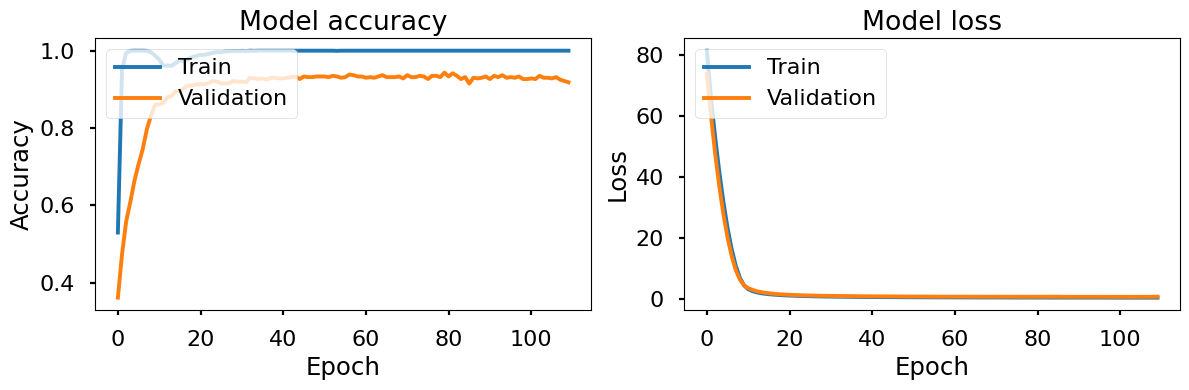

training history {'loss': [81.43437194824219, 65.77794647216797, 53.03323745727539, 41.6737060546875, 31.719270706176758, 23.214672088623047, 16.230093002319336, 10.743969917297363, 6.7975592613220215, 4.343669891357422, 3.0963408946990967, 2.467949867248535, 2.074723720550537, 1.7979203462600708, 1.5991504192352295, 1.4519795179367065, 1.3318731784820557, 1.2384443283081055, 1.1396499872207642, 1.0665020942687988, 1.0099531412124634, 0.9559290409088135, 0.9114654660224915, 0.8631361126899719, 0.8280479907989502, 0.7896187901496887, 0.7591876983642578, 0.7332078814506531, 0.7076864838600159, 0.6841505169868469, 0.6691936254501343, 0.6468604207038879, 0.6303578019142151, 0.6122140288352966, 0.5993109345436096, 0.5812143683433533, 0.5670452117919922, 0.5560515522956848, 0.5434679388999939, 0.5350779294967651, 0.5248878598213196, 0.5154531598091125, 0.5043114423751831, 0.4977242946624756, 0.4887523353099823, 0.48105403780937195, 0.4782116711139679, 0.4699379503726959, 0.4634232223033905, 

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

temp_model = -1

def do_experiment(finetune_percent = 0.2, use_selfsupervised_backbone = True, nfolds_to_test=5):
  use_reference_warmup = False  # should we train few epochs with x_reference


  if finetune_percent < 1.0:
    xtrainpct, xtestpct, ytrainpct, ytestpct = train_test_split(x_finetune, y_finetune,
                                                                train_size=finetune_percent, random_state=42,
                                                                stratify=y_finetune,
                                                                shuffle=True)
    x_finetune_select, y_finetune_select = xtrainpct, ytrainpct
  else:
    x_finetune_select, y_finetune_select = x_finetune, y_finetune


  # fold validation and testing
  num_folds=5
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

  #bm_model_loaded.summary()

  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train_indices, val_indices in kfold.split(x_finetune_select, y_finetune_select):
      # Generate batches from indices
      xtrain, xval = x_finetune_select[train_indices], x_finetune_select[val_indices]
      ytrain, yval = y_finetune_select[train_indices], y_finetune_select[val_indices]
      if use_selfsupervised_backbone:
        bm_model_loaded = keras.models.load_model("/content/drive/MyDrive/repl_breastcancer_pretraining_1_4")
      else:
        bm_model_loaded = build_twin() # use random weights model
      #bm_model_loaded.summary(
      # Do not freeze weights
      model = tf.keras.models.Sequential([
        bm_model_loaded,
        tf.keras.layers.Dense(
            30,
            activation="softmax",
            kernel_regularizer=tf.keras.regularizers.L1L2(0.05,0.05)
        )
      ])

      # Generate a print
      print('------------------------------------------------------------------------')
      print(f'Training for fold {fold_no} ...')

      if use_reference_warmup:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5, beta_2=0.999), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history=model.fit(x_reference, y_reference, batch_size=512, epochs=5,
                                          callbacks=[
                                keras.callbacks.EarlyStopping(
                                    monitor='val_accuracy',
                                    patience=10,
                                    restore_best_weights=True
                                ),
                                keras.callbacks.ReduceLROnPlateau(
                                    monitor='val_loss',
                                    factor=0.1,
                                    patience=30,
                                    min_lr=0.0000005
                                )
                            ], validation_split=0.2
        )

        # Plot training history
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 4))

        # Plot training & validation accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

        print("train with xref and yref light")
        model.evaluate(x_test, y_test)

      model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005, beta_1=0.9, beta_2=0.999), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

      history = model.fit(xtrain, ytrain,
                          validation_data=(xval, yval),
                          # 256
                          batch_size=256,
                          epochs=200,
                          callbacks=[
                              keras.callbacks.EarlyStopping(
                                  monitor='val_accuracy',
                                  patience=30,
                                  restore_best_weights=True
                              ),
                              keras.callbacks.ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.1,
                                  patience=30,
                                  min_lr=0.0000005
                              )
                          ]
                          #validation_split=0.2
                          )

      # Plot training history
      import matplotlib.pyplot as plt
      plt.figure(figsize=(12, 4))

      # Plot training & validation accuracy
      plt.subplot(1, 2, 1)
      plt.plot(history.history['accuracy'])
      plt.plot(history.history['val_accuracy'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')

      # Plot training & validation loss
      plt.subplot(1, 2, 2)
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')

      plt.tight_layout()
      plt.show()
      history_str = str(history.history)
      print (f"training history {history_str}")


      result = model.evaluate(x_test, y_test)
      result_str = "test loss, test acc:" + str(result)
      print(f"Result: use backbone : {use_selfsupervised_backbone}, test_accuracy finetune_percent {finetune_percent}, fold_number {fold_no}, test_results {result_str}")
      result_dict = dict(zip(model.metrics_names, result))
      result_dict_str = str(result_dict)
      print(result_dict_str)

      # save result_dict_str into a txt file
      file_name = f"result_{int(finetune_percent * 100)}_backbone_{use_selfsupervised_backbone}"

      # Save the string to a file
      with open(file_name, "a") as file:
          file.write("\n"+result_dict_str)

      print(f"String saved to {file_name}")

      # You can utilize temp_model for creating certain plots like confusion matricies
      global temp_model
      temp_model = model

      fold_no = fold_no + 1
      if fold_no > nfolds_to_test:
        return

for pct in [10, 20, 100]:
  for usebackbone in [True, False]:
    print (f"Running finetune_pct  {pct} usebackbone {usebackbone}")
    do_experiment(pct/100.0, usebackbone,  nfolds_to_test=5)


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20}) # Adjust the value (20) as needed

Confusion matrix plot used in Figure 8

94/94 [==============================] - 2s 6ms/step


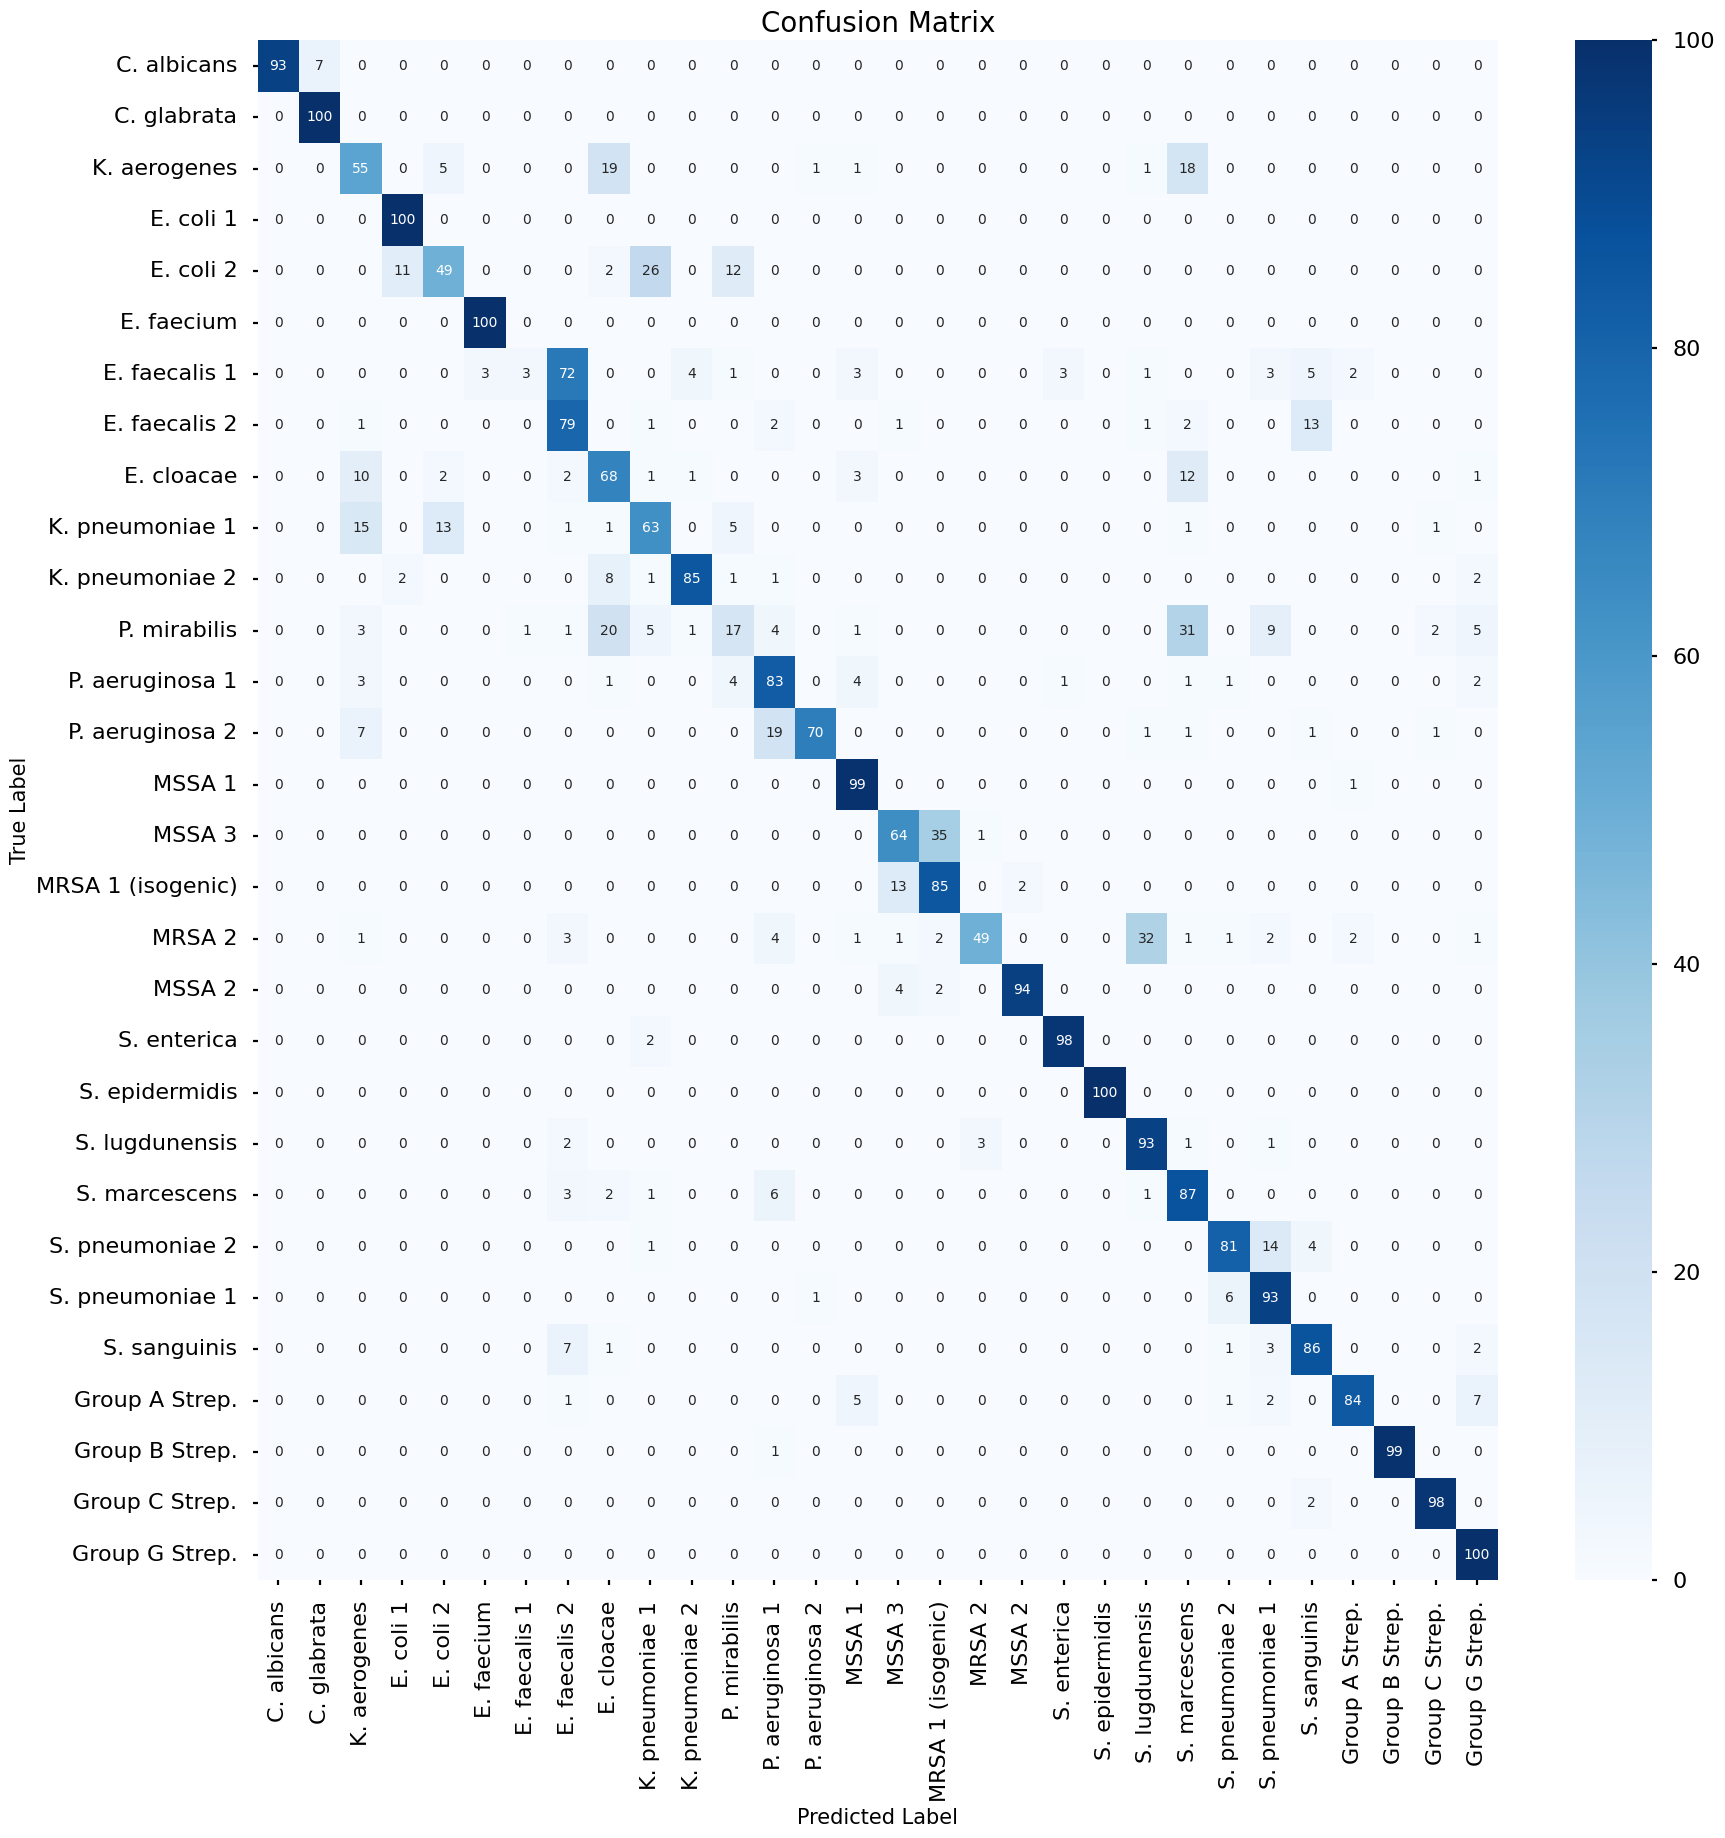

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


y_pred = np.argmax(temp_model.predict(x_test), axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[STRAINS[i] for i in range(30)],
            yticklabels=[STRAINS[i] for i in range(30)])
plt.xlabel("Predicted Label", fontsize=FONTSIZE_AXIS)
plt.ylabel("True Label", fontsize=FONTSIZE_AXIS)
plt.title("Confusion Matrix", fontsize=FONTSIZE_TITLE)
plt.show()